# DATA@ANZ Virtual Internship Task 2

The goal of this challenge is to train a machine learning model to predict the salaries of the customers. 

In my solution, I use a Random Forest and an XGBoost regressors to train the model. 

But first, we'll have to go through some data pre processing steps.

### Step 1: Imports 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_graphviz
from pre_processing import * # My custom code which helps me in data processing. Importing it to keep the notebook clean.
import pandas.api.types as ptypes

from IPython.display import display
import pandas.api.types as ptypes

from sklearn import metrics

In [6]:
df=pd.read_excel("ANZ synthesised transaction dataset.xlsx")
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


### Step 2: Data Pre-processing

As we found out in the previous task, these columns don't provide us with any useful insights and hence, I remove them. 

In [7]:
df.drop(['bpay_biller_code','merchant_code','currency','country','date'],axis=1,inplace=True)
df.columns

Index(['status', 'card_present_flag', 'account', 'long_lat', 'txn_description',
       'merchant_id', 'first_name', 'balance', 'gender', 'age',
       'merchant_suburb', 'merchant_state', 'extraction', 'amount',
       'transaction_id', 'customer_id', 'merchant_long_lat', 'movement'],
      dtype='object')

Although the goal is to predict the salaries of the customers, there's not specific salary column. Hence, I have to split the data in such a way that the "txn_description" columns specify Pay or Salary. This also makes a lot of other columns redundant. Hence, I remove them as well. 

In [8]:
salary_df=df[df['txn_description']=='PAY/SALARY']
salary_df=salary_df.drop(['txn_description','card_present_flag','merchant_suburb','merchant_state'],axis=1)
salary_df.head()

,status,account,long_lat,merchant_id,first_name,balance,gender,age,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement
50,posted,ACC-588564840,151.27 -33.76,NaN,Isaiah,8342.11,M,23,2018-08-01T11:00:00.000+0000,3903.95,9ca281650e5d482d9e53f85e959baa66,CUS-1462656821,NaN,credit
61,posted,ACC-1650504218,145.01 -37.93,NaN,Marissa,2040.58,F,23,2018-08-01T12:00:00.000+0000,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,CUS-2500783281,NaN,credit
64,posted,ACC-3326339947,151.18 -33.80,NaN,Eric,3158.51,M,22,2018-08-01T12:00:00.000+0000,983.36,bd62b1799a454cedbbb56364f7c40cbf,CUS-326006476,NaN,credit
68,posted,ACC-3541460373,145.00 -37.83,NaN,Jeffrey,2517.66,M,24,2018-08-01T13:00:00.000+0000,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,CUS-1433879684,NaN,credit
70,posted,ACC-2776252858,144.95 -37.76,NaN,Kristin,2271.79,F,43,2018-08-01T13:00:00.000+0000,1068.04,f50ccf1195214d14a0acbfcb5a265193,CUS-4123612273,NaN,credit


Apart from just the date, various more insights can be derived if we split the date into many more columns. Here I use my custom built code which I have imported in the first cell. 

In [9]:
add_datepart(salary_df,'extraction')
salary_df.head()

,status,account,long_lat,merchant_id,first_name,balance,gender,age,amount,transaction_id,customer_id,merchant_long_lat,movement,extractionYear,extractionMonth,extractionWeek,extractionDay,extractionDayofweek,extractionDayofyear,extractionIs_month_end,extractionIs_month_start,extractionIs_quarter_end,extractionIs_quarter_start,extractionIs_year_end,extractionIs_year_start,extractionElapsed
50,posted,ACC-588564840,151.27 -33.76,NaN,Isaiah,8342.11,M,23,3903.95,9ca281650e5d482d9e53f85e959baa66,CUS-1462656821,NaN,credit,2018,8,31,1,2,213,False,True,False,False,False,False,1533121200
61,posted,ACC-1650504218,145.01 -37.93,NaN,Marissa,2040.58,F,23,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,CUS-2500783281,NaN,credit,2018,8,31,1,2,213,False,True,False,False,False,False,1533124800
64,posted,ACC-3326339947,151.18 -33.80,NaN,Eric,3158.51,M,22,983.36,bd62b1799a454cedbbb56364f7c40cbf,CUS-326006476,NaN,credit,2018,8,31,1,2,213,False,True,False,False,False,False,1533124800
68,posted,ACC-3541460373,145.00 -37.83,NaN,Jeffrey,2517.66,M,24,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,CUS-1433879684,NaN,credit,2018,8,31,1,2,213,False,True,False,False,False,False,1533128400
70,posted,ACC-2776252858,144.95 -37.76,NaN,Kristin,2271.79,F,43,1068.04,f50ccf1195214d14a0acbfcb5a265193,CUS-4123612273,NaN,credit,2018,8,31,1,2,213,False,True,False,False,False,False,1533128400


To convert the categorial columns so that the model can understand them there are various techniques including one-hot encoding and label encoding. But introducing new columns like these introduce more computation without providing more insights, hence I use my custom code to convert the codes ino category type and not integers. 

In [0]:
train_cats(salary_df)

As we saw in the last task, there are huge amount of outliers in the amount and balance columns and so, I log normalize them. 

In [0]:
salary_df[['amount','balance']]=salary_df[['amount','balance']].apply(lambda x: np.log(x+1))

And just like in the previous task, I convert the categorial long, lat to numeric values. 

In [0]:
salary_df[['Long','Lat']] = salary_df.long_lat.str.split(expand=True) 
salary_df=salary_df.drop(['long_lat'],axis=1)

In [0]:
salary_df[['Long','Lat']] = salary_df[['Long','Lat']].apply(pd.to_numeric)

In [14]:
salary_df.describe()

,balance,age,amount,extractionYear,extractionMonth,extractionWeek,extractionDay,extractionDayofweek,extractionDayofyear,extractionElapsed,Long,Lat
count,883.000000,883.000000,883.000000,883.0,883.000000,883.000000,883.000000,883.000000,883.00000,8.830000e+02,883.000000,883.000000
mean,9.033044,32.631937,7.393238,2018.0,9.016988,37.578709,15.845980,1.967157,259.01812,1.537109e+09,143.479921,-37.750136
std,1.032263,12.276731,0.550652,0.0,0.832139,3.815067,8.881115,1.480810,26.60511,2.298684e+06,15.407227,48.163419
min,6.602126,18.000000,6.357842,2018.0,8.000000,31.000000,1.000000,0.000000,213.00000,1.533121e+09,114.620000,-573.000000
25%,8.368924,22.000000,6.922319,2018.0,8.000000,34.000000,8.000000,1.000000,236.00000,1.535114e+09,143.880000,-37.760000
50%,8.927120,30.000000,7.394788,2018.0,9.000000,38.000000,16.000000,2.000000,260.00000,1.537189e+09,145.170000,-33.960000
75%,9.573020,40.000000,7.839793,2018.0,10.000000,41.000000,24.000000,3.000000,282.00000,1.539104e+09,150.920000,-31.900000
max,12.495489,78.000000,9.086700,2018.0,10.000000,44.000000,31.000000,4.000000,304.00000,1.541005e+09,255.000000,-12.370000


For further processing, I will normalize all the numeric columns using minmax scaler. 

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

salary_df[['amount','balance','age','extractionWeek','extractionDay','extractionDayofyear','extractionElapsed','Long','Lat']]=sc.fit_transform(salary_df[['amount','balance','age','extractionWeek','extractionDay','extractionDayofyear','extractionElapsed','Long','Lat']])

### Step 3: Initial Model Fit

In [0]:
X, y, nas = proc_df(salary_df, 'amount')

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 706 samples.
Testing set has 177 samples.


I start with using a simple Random Forest Regressor without specifying any parameters. Just the defaults. 

In [18]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
m.score(X_test,y_test)

0.8671401758604343

Wow! That's pretty good for a simple model. 

Now I'll try with an XGBoost Regressor which is like Random Forest on steroids. 

In [45]:
import xgboost as xgb
model=xgb.XGBRegressor(random_state=1,learning_rate=0.3)

model.fit(X_train, y_train)
model.score(X_test,y_test)

[03:50:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9458726697857291

Great! That is so much better. 

### Step 4: Inference

Let us see which feature was most responsible for tour result. 

In [61]:
fi=pd.DataFrame({'cols':X_train.columns, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
fi.head(20)

,cols,imp
4,balance,0.150567
3,first_name,0.144748
6,age,0.137118
23,extractionElapsed,0.098610
15,extractionDayofweek,0.094218
25,Lat,0.079071
1,account,0.072304
24,Long,0.066899
16,extractionDayofyear,0.051762
5,gender,0.046602


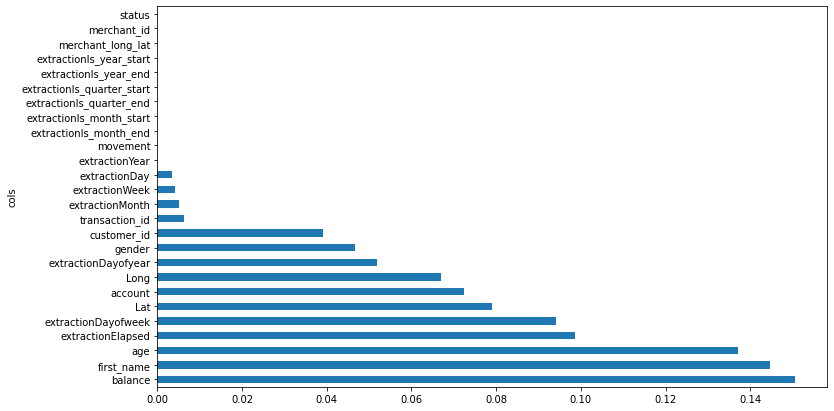

In [62]:
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

Unsurprisingly, account balance and age come out on top, but first name seems weird. 

Let's try and remove the columns which affect our model very less. 

In [0]:
to_keep = fi[fi.imp>0.03].cols; len(salary_df.columns),len(to_keep)
df_keep = X[to_keep].copy()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size = 0.2, random_state = 0)
model.fit(X_train, y_train)
model.score(X_test,y_test)

[04:24:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9478095308221777

The model did improve, but insignificantly. 